# Feature Linearization on LFP Dataset Example

$$f(DQ_{100-10}) = w^{\top} (DQ_{100-10}-\overline{DQ}_{100-10}) +  \overline f({DQ}_{100-10})$$

This is the (prediction step of the) an linear regression algorithm. 

Similarly, a feature can be approximated by a Taylor series: 

$$f(\mathbf{x}) = f(\mathbf{a}) + (\mathbf{x} - \mathbf{a})^\mathsf{T} D f(\mathbf{a}) + \cdots$$

The two above can be turned into a very similar form and then compared with another to inspire better features!

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.cross_decomposition import PLSRegression

# Useful for debugging
from importlib import reload

# IPython Libraries
import IPython
import ipywidgets
from ipywidgets import interact

# Custom packages
from src.src_lin_feature import plot_linearized_nonlinear_comp
from src.src_lin_feature import plot_linear_model_weights_and_features
from src.src_lin_feature import plot_linear_model_weights_and_features_old
from src.src_lin_feature import plot_prediction_results
from src.src_lin_feature import truncate_colormap

import src.featlin
from src.featlin import regress_linearized_coeff
from src.featlin import jax_moment

# Autograd implementation, auto differentiation toolkit
import jax.numpy as jnp
from jax import grad
from jax import jacfwd

In [2]:
# For demonstration purposes we wrote most of the logic down here explicitly to 
# match the description in the paper (LINK), even though it's not according to PEP 8 style guide. 
# Load the LFP Dataset
save_plots = 0
path_save = './Results/'

lfp_df = pd.read_csv('lfp_slim.csv', index_col=0)
X_lpf = np.array(lfp_df.iloc[:, 0:1000])

X_train = np.array(lfp_df.loc[lfp_df.iloc[:, 1002]==0, :].iloc[:, :1000])
y_train = np.array(lfp_df.loc[lfp_df.iloc[:, 1002]==0, :].iloc[:, 1000])
y_train = np.log10(y_train)

X_test = np.array(lfp_df.loc[lfp_df.iloc[:, 1002]==1, :].iloc[:, :1000])
y_test = np.array(lfp_df.loc[lfp_df.iloc[:, 1002]==1, :].iloc[:, 1000])
y_test = np.log10(y_test)

X_test2 = np.array(lfp_df.loc[lfp_df.iloc[:, 1002]==2, :].iloc[:, :1000])
y_test2 = np.array(lfp_df.loc[lfp_df.iloc[:, 1002]==2, :].iloc[:, 1000])
y_test2 = np.log10(y_test2)

X_dict = {'train':np.expand_dims(X_train, axis=2), 'test': np.expand_dims(X_test, axis=2), 'test2': np.expand_dims(X_test2, axis=2)}
y_dict = {'train':y_train, 'test': y_test, 'test2': y_test2}

## Calculation of Taylor1 linearized regression coefficients

### Log Variance Feature

In [3]:
a = np.mean(X_train, axis=0)
ln_var_a = np.log(np.var(a))

d_a = a-a.mean()
e_sums_a = np.sum(np.power(d_a, 2))

# The factors m and b are still missing. 
# Estimation via OLS regression.
x_hat_var = np.zeros(len(X_train))

for i in range(len(X_train)):
    # np.dot: If both a and b are 1-D arrays, it is inner product of vectors (without complex conjugation).
    x_hat_var[i] = ln_var_a + (2/e_sums_a)*np.dot((X_train[i, :]-a), d_a)
    
reg = LinearRegression(fit_intercept=True).fit(x_hat_var.reshape(-1, 1), y_train-y_train.mean())

m = reg.coef_
b = reg.intercept_

linearized_log_var_coef = (2*m)/(e_sums_a) * d_a
linearized_log_var_coef_norm= (linearized_log_var_coef-linearized_log_var_coef.min())
linearized_log_var_coef_norm /= np.abs(linearized_log_var_coef_norm).max()
linearized_log_var_coef_coef = m*np.log(np.var(a)) + b

# How good is the linear approximation:
mlg_varX = np.mean(np.log(np.var(X_train)))
print('The value of the of log(var(mean(DQ))) is' + f' {ln_var_a:.2f}')
print('The value of the of mean(log(var((DQ))) is' + f' {mlg_varX:.2f}')
rel_deviation = np.abs((mlg_varX-ln_var_a))/mlg_varX
print('The the deviation from linearity at the center of the Taylor aproximation is thus  ' + f' {rel_deviation*100:.2f}%')

The value of the of log(var(mean(DQ))) is -8.29
The value of the of mean(log(var((DQ))) is -7.79
The the deviation from linearity at the center of the Taylor aproximation is thus   -6.41%


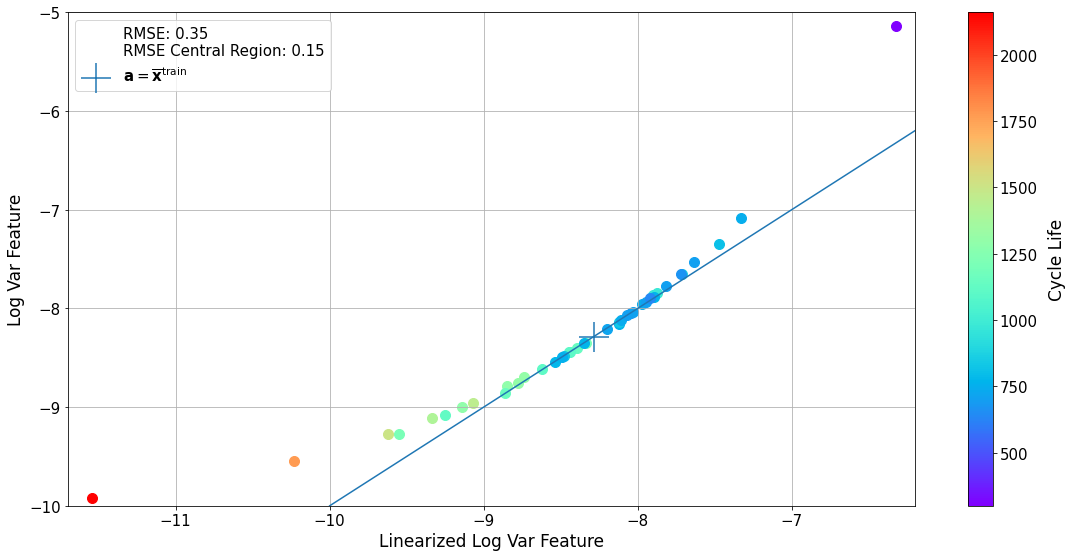

In [4]:
log_var_feature = np.log(np.var(X_train, axis=1, ddof=1))

title = 'Linearized Log Variance Feature vs Log Variance Feature'
xlabel = 'Linearized Log Var Feature'
ylabel = 'Log Var Feature'
cmap = cm.get_cmap('rainbow')

plot_linearized_nonlinear_comp(log_var_feature, x_hat_var, y_train, ln_var_a,
                               cmap=cmap, title=title, xlabel=xlabel, ylabel=ylabel, 
                               path=path_save, save=save_plots)

In [5]:
# PLS model as reference
pls1 = PLSRegression(n_components=1, tol=1e-7, scale=False).fit(X_train, (y_train-y_train.mean()))
pls1comp_coef_norm = pls1.coef_/pls1.coef_.max()

pls2 = PLSRegression(n_components=2, tol=1e-7, scale=False).fit(X_train, y_train-y_train.mean())
pls2comp_coef_norm = pls2.coef_/pls1.coef_.max()

# RR Model as Reference
rr = Ridge(alpha=0.5)
rr = rr.fit(X_train, (y_train-y_train.mean()))
rr_coef = np.expand_dims(rr.coef_, axis=1) # otherwise shape mismatch with PLS model coefficients

In [6]:
Vdlin = np.linspace(3.5,2,X_train.shape[1])
cmap_reds = truncate_colormap(plt.get_cmap('Reds_r'), 0, 0.7)

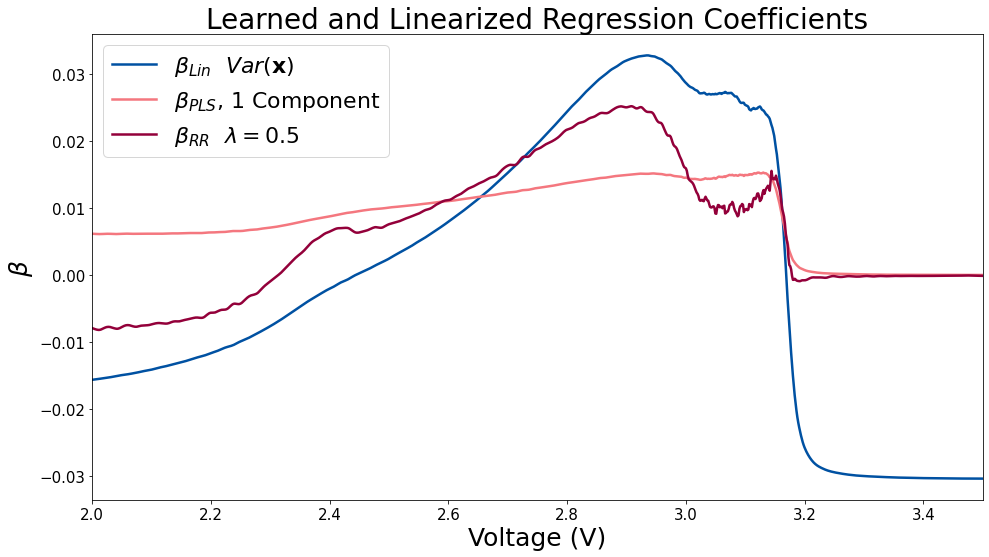

In [7]:
colors = ['#0051a2', '#97964a', '#f4777f', '#93003a']
fig, axs = plt.subplots(figsize=(14,8))
for i in [1]:  
    axs.plot(np.linspace(3.5,2.0,1000), linearized_log_var_coef, label=r'$\beta_{Lin}$  $Var(\mathbf{x})$', lw=2.5, color=colors[0])
    axs.plot(np.linspace(3.5,2.0,1000), pls1.coef_, label=r'$\beta_{PLS}$, 1 Component', lw=2.5, color=colors[2])
    axs.plot(np.linspace(3.5,2.0,1000), rr_coef, label=r'$\beta_{RR}$  $\lambda=0.5$', lw=2.5, color=colors[3])
    # axs.grid()
    axs.legend(loc=2, fontsize=22)
    
axs.set_title('Learned and Linearized Regression Coefficients', fontsize=28)
axs.set_xlabel('Voltage (V)', fontsize=25)
axs.set_ylabel(r'$\beta$', fontsize=25)
axs.set_xlim([2.0,3.5])
plt.tight_layout()
if save_plots:
    plt.savefig('Var_Feature_Lin.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Log Energy Feature

In [8]:
# Still working on this. There might be one or two sign errors somewhere 

a_minus = np.mean(-X_train, axis=0)
ln_mean_a = np.log(np.mean(a_minus))
inv_a = np.ones(X_train.shape[1])*(1/np.sum(a_minus))

x_hat_mean = np.zeros(len(X_train))

for i in range(len(X_train)):
    # np.dot: If both a and b are 1-D arrays, it is inner product of vectors (without complex conjugation).
    x_hat_mean[i] = ln_mean_a + np.dot((-X_train[i, :]-a_minus), inv_a)

# The factors m and b are still missing. 
# Estimation via OLS regression
reg = LinearRegression(fit_intercept=True).fit(x_hat_mean.reshape(-1, 1), (y_train-y_train.mean()))

m = reg.coef_
b = reg.intercept_

linearized_log_mean_coef = m * -inv_a
linearized_log_mean_const_coef = m*np.log(np.mean(a_minus)) + b

# How good is the linear approximation:
mln_meanX = np.mean(np.log(np.mean(-X_train)))
print('The value of the of log(var(mean(DQ))) is' + f' {ln_mean_a:.2f}')
print('The value of the of mean(log(var((DQ))) is' + f' {mln_meanX:.2f}')
rel_deviation = np.abs((ln_mean_a-mln_meanX))/mln_meanX
print('The the deviation from linearity at the center of the Taylor aproximation is thus  ' + f' {rel_deviation*100:.2f}%')
# Reason: The mean is linear! The logarithm is not, but due to the linearity of the mean the approximation is excact. 

The value of the of log(var(mean(DQ))) is -3.78
The value of the of mean(log(var((DQ))) is -3.78
The the deviation from linearity at the center of the Taylor aproximation is thus   -0.00%


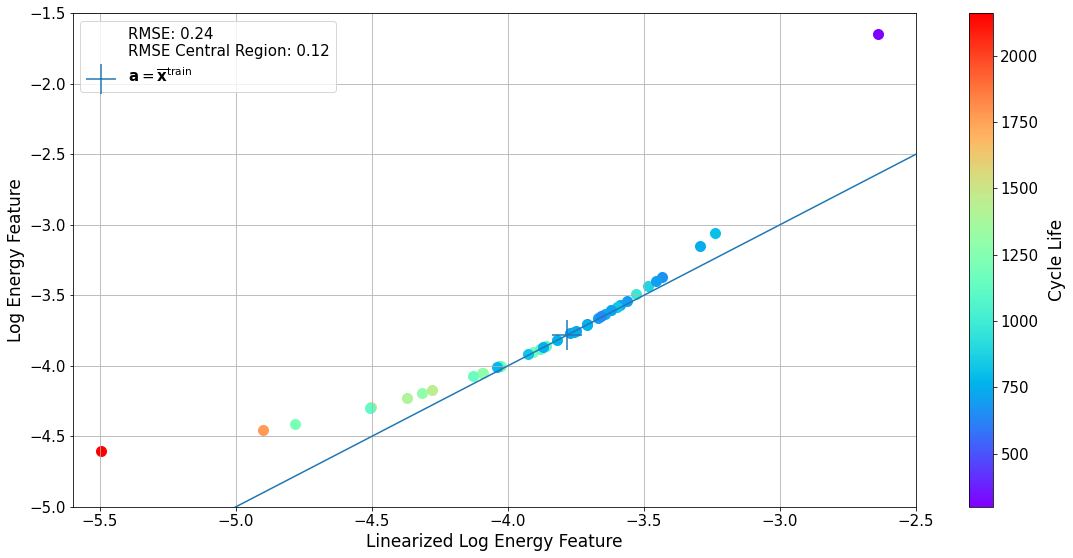

In [9]:
log_mean_feature = np.log(np.mean(-X_train, axis=1))

title ='Linearized Log Energy Feature vs Log Energy Feature'
xlabel='Linearized Log Energy Feature'
ylabel='Log Energy Feature'

cmap = cm.get_cmap('rainbow')

plot_linearized_nonlinear_comp(log_mean_feature, x_hat_mean, y_train, ln_mean_a,
                               cmap=cmap, xlim=[-5.6,-2.5], ylim=[-5,-1.5], title=title, 
                               xlabel=xlabel, ylabel=ylabel, path=path_save, save=save_plots)

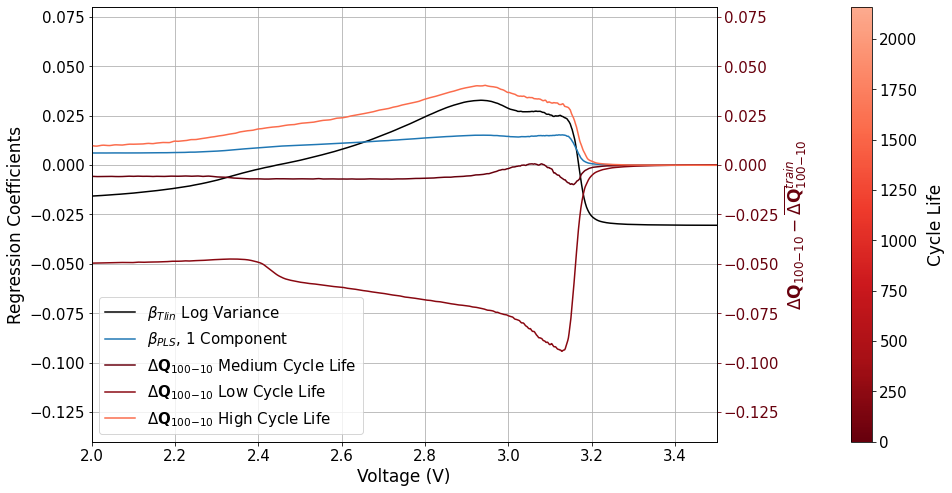

In [10]:
# Old way of plotting used in JS master's thesis, plot is difficutl to read. 
# Therfore not recommended for further use.

# label_lin = r'$\bm\beta_{Tlin}$ Log Variance'
# label_reg = r'$\bm\beta_{PLS}$, 1 Component'
label_lin = r'$\beta_{Tlin}$ Log Variance'
label_reg = r'$\beta_{PLS}$, 1 Component'
plot_linear_model_weights_and_features_old(
    linearized_log_var_coef, pls1.coef_, X_train, y_train, Vdlin,
    label_lin=label_lin, label_reg=label_reg, path=path_save, save=save_plots)

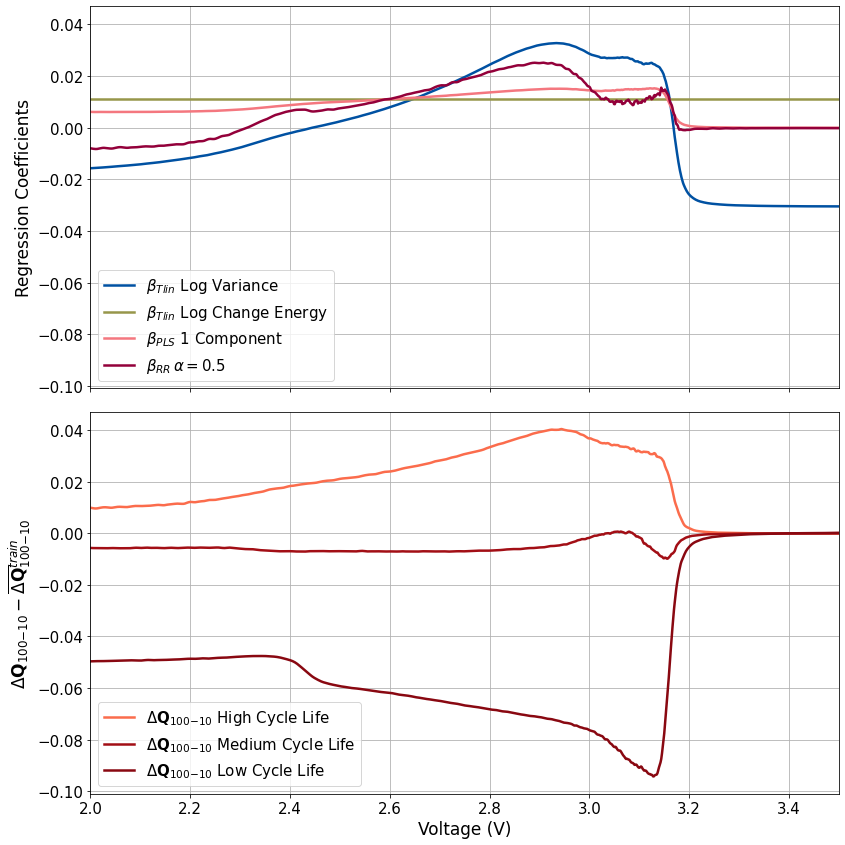

In [11]:
# label_lin = [r'$\bm\beta_{Tlin}$ Log Variance',
#             r'$\bm\beta_{Tlin}$ Log Change Energy',
#            ]
label_lin = [r'$\beta_{Tlin}$ Log Variance',
             r'$\beta_{Tlin}$ Log Change Energy',
            ]
lin_coef = [linearized_log_var_coef, 
            linearized_log_mean_coef,
           ]

label_reg = [r'$\beta$$_{PLS}$ 1 Component',
             r'$\beta_{RR} \, \alpha = 0.5$'
            ]
# r'$\beta$$_{PLS}$ 2 Components',
#label_reg = [r'$\beta_{PLS}$, 1 Component',
#             r'$\beta_{RR}$,',
#            ]

# pls2.coef_,
reg_coef = [pls1.coef_, 
            rr_coef,
           ]

plot_linear_model_weights_and_features(
    lin_coef, reg_coef, X_train, y_train, Vdlin,
    label_lin=label_lin, label_reg=label_reg, path=path_save, save=save_plots)

### Predicting

In [12]:
# Prediction step
def predict(X, coef, X_train_mean, y_train_mean):
    '''Simple dot product to obtain mean centered predictions!
    We are using this function here to showcase that regardless 
    of whether we are using learned or linearized regression coefficients, 
    the prediction step is excatly the same.
    '''
    y_pred = np.dot(X-X_train_mean, coef)+y_train_mean
    return y_pred

def predict_multiple(X_dict, coef, y_train, feat_ind):
    '''Helper function calling predict in a loop
    '''
    X_train_mean = np.mean(X_dict['train'][:,:,feat_ind], axis=0)
    y_train_mean = y_train.mean()
    y_pred = dict.fromkeys(X_dict.keys())
    for key in X_dict.keys():
        y_pred[key] = predict(X_dict[key][:,:,feat_ind], coef, X_train_mean, y_train_mean)
    return y_pred

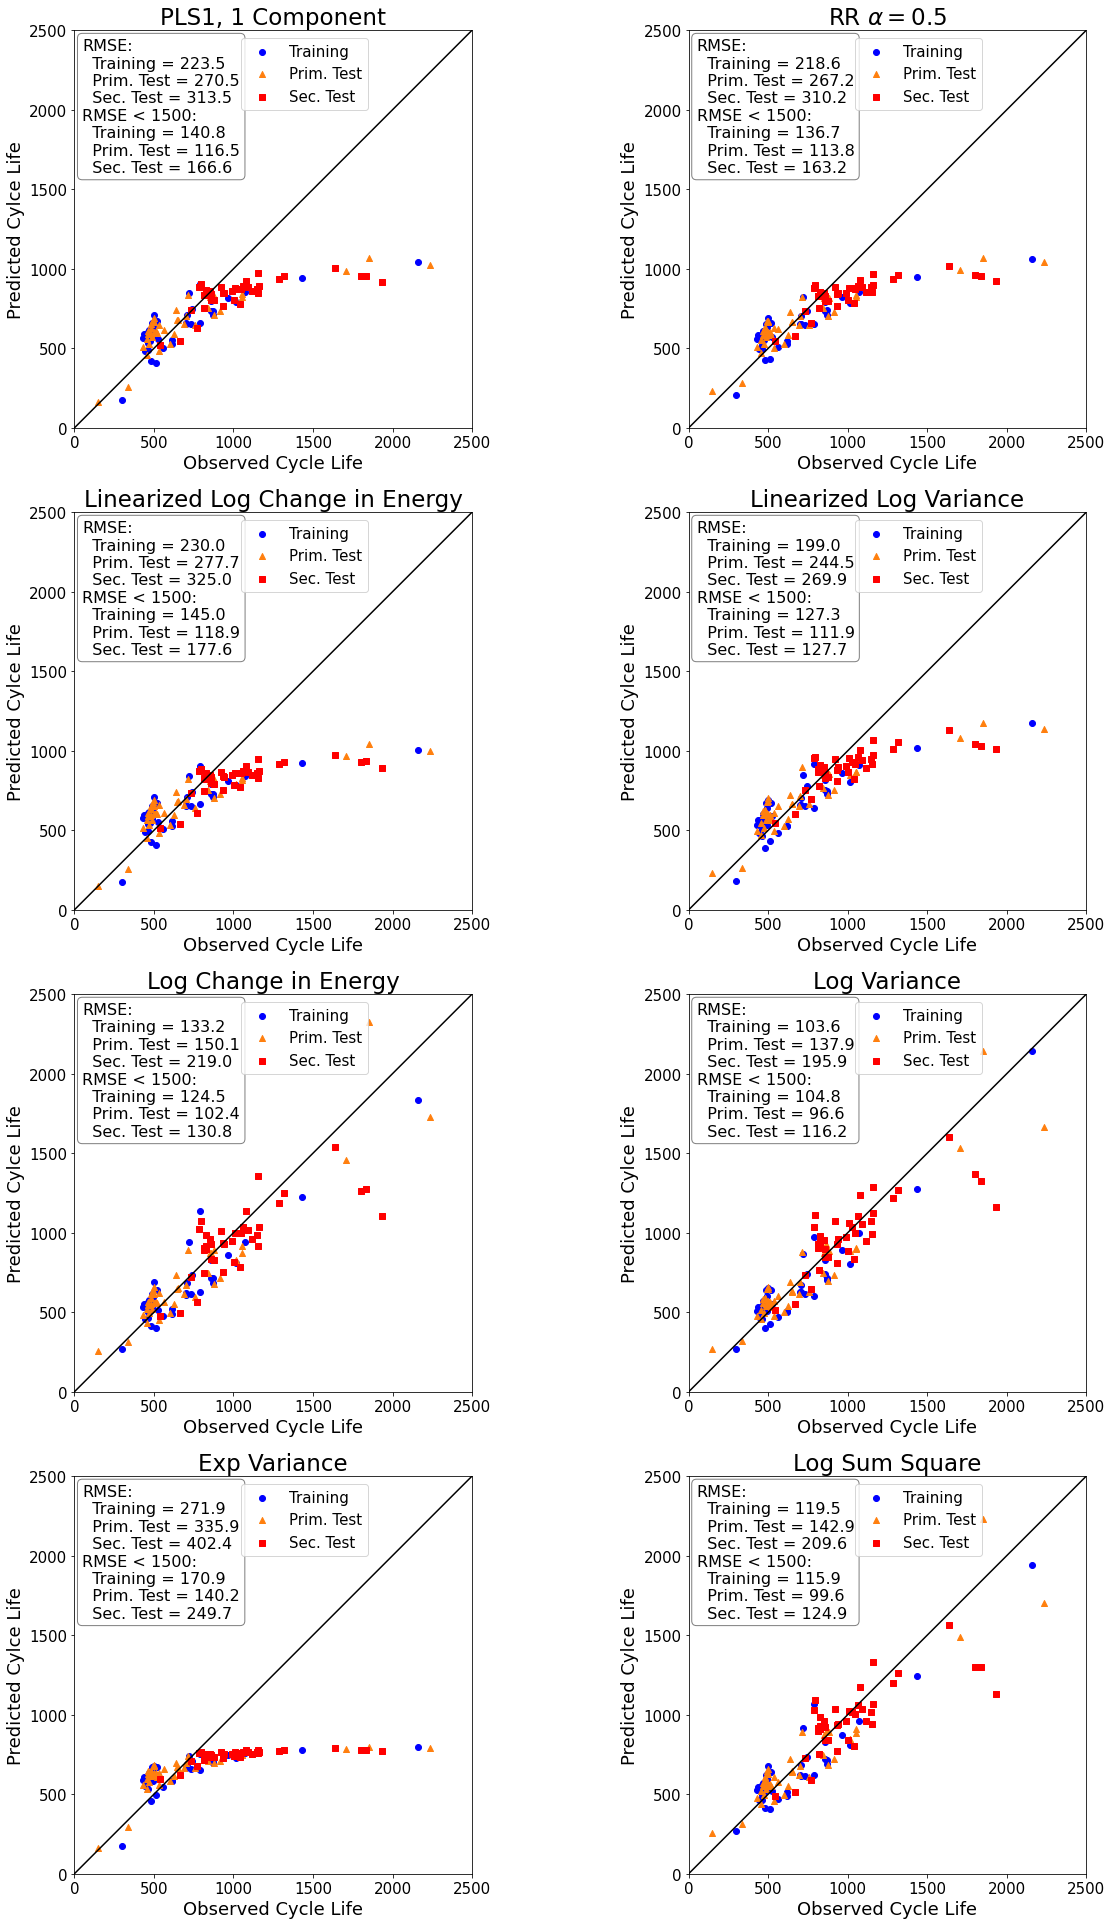

In [13]:
feat_ind = 0 
y_pred_taylor_log_var = predict_multiple(X_dict, linearized_log_var_coef, y_train, feat_ind)
y_pred_taylor_log_mean = predict_multiple(X_dict, linearized_log_mean_coef, y_train, feat_ind)

y_pred_pls1 = predict_multiple(X_dict, pls1.coef_, y_train, feat_ind)
y_pred_pls2 = predict_multiple(X_dict, pls2.coef_, y_train, feat_ind)
y_pred_rr = predict_multiple(X_dict, rr_coef, y_train, feat_ind)

# Log mean (Change in energy!) 
log_mean = dict.fromkeys(X_dict.keys())
y_pred_log_mean = dict.fromkeys(X_dict.keys())

for key in X_dict.keys(): 
    log_mean[key] = np.log(-np.mean(X_dict[key], axis=1))

# Explicit subtraction of the mean not necessary, ususally done anyways during the fitting process itself. 
# However, it is implemented here explicitly to to show analygies. 
reg_log_mean = LinearRegression(fit_intercept=True).fit(log_mean['train'], (y_dict['train']-y_dict['train'].mean()))

for key in X_dict.keys(): 
    y_pred_log_mean[key] = reg_log_mean.predict(log_mean[key]) + y_dict['train'].mean()

# Log Variance! 
log_var = dict.fromkeys(X_dict.keys())
y_pred_log_var = dict.fromkeys(X_dict.keys())

for key in X_dict.keys(): 
    log_var[key] = np.log(np.var(X_dict[key], axis=1, ddof=1))

# Explicit subtraction of the mean not necessary, ususally done anyways during the fitting process itself. 
# However, it is implemented here explicitly to to show analygies. 
reg_log_var = LinearRegression(fit_intercept=True).fit(log_var['train'], (y_dict['train']-y_dict['train'].mean()))

for key in X_dict.keys(): 
    y_pred_log_var[key] = reg_log_var.predict(log_var[key]) + y_dict['train'].mean()

# Exp Variance! 
exp_var = dict.fromkeys(X_dict.keys())
y_pred_exp_var = dict.fromkeys(X_dict.keys())

for key in X_dict.keys(): 
    exp_var[key] = np.exp(np.var(X_dict[key], axis=1, ddof=1))

# Explicit subtraction of the mean not necessary, ususally done anyways during the fitting process itself. 
# However, it is implemented here explicitly to to show analygies. 
reg_exp_var = LinearRegression(fit_intercept=True).fit(exp_var['train'], (y_dict['train']-y_dict['train'].mean()))

for key in X_dict.keys(): 
    y_pred_exp_var[key] = reg_exp_var.predict(exp_var[key]) + y_dict['train'].mean()

# Sumsquares! 
sum_sq = dict.fromkeys(X_dict.keys())
y_pred_sum_sq = dict.fromkeys(X_dict.keys())

for key in X_dict.keys(): 
    sum_sq[key] = np.log(np.sum(np.power(X_dict[key], 2), axis=1))

# Explicit subtraction of the mean not necessary, ususally done anyways during the fitting process itself. 
# However, it is implemented here explicitly to to show analygies. 
reg_sum_sq = LinearRegression(fit_intercept=True).fit(sum_sq['train'], (y_dict['train']-y_dict['train'].mean()))

for key in X_dict.keys(): 
    y_pred_sum_sq[key] = reg_sum_sq.predict(sum_sq[key]) + y_dict['train'].mean()

## Plots of regression results

# Regression results plot: 
fig, ax = plt.subplots(4,2, figsize=(18,27))

# plot_prediciton results turns latex off, for the plots, not needed anymore.
# The way this is done by changing runtime configuration parameters is not ideal, but it works for now
# PLS1
ax[0,0] = plot_prediction_results(
    y_dict, y_pred_pls1, base=10, title='PLS1, 1 Component',
    return_ax=1, ax=ax[0,0],  path=path_save, save=0)

# RR
ax[0,1] = plot_prediction_results(
    y_dict, y_pred_rr, base=10, title=r'RR $\alpha=0.5$',
    return_ax=1, ax=ax[0,1],  path=path_save, save=0)

# Lin Log Mean
ax[1,0] = plot_prediction_results(
    y_dict, y_pred_taylor_log_mean, base=10, title='Linearized Log Change in Energy',
    return_ax=1, ax=ax[1,0],  path=path_save, save=0)

# Lin Log Var
ax[1,1] = plot_prediction_results(
    y_dict, y_pred_taylor_log_var, base=10, title='Linearized Log Variance',
    return_ax=1, ax=ax[1,1],  path=path_save, save=0)

# Log Mean
ax[2,0] = plot_prediction_results(
    y_dict, y_pred_log_mean, base=10, title='Log Change in Energy',
    return_ax=1, ax=ax[2,0],  path=path_save, save=0)

# Log Var
ax[2,1] = plot_prediction_results(
    y_dict, y_pred_log_var, base=10, title='Log Variance',
    return_ax=1, ax=ax[2,1],  path=path_save, save=0)

# Exp Var
ax[3,0] = plot_prediction_results(
    y_dict, y_pred_exp_var, base=10, title='Exp Variance',
    return_ax=1, ax=ax[3,0],  path=path_save, save=0)

# Sum Square
ax[3,1] = plot_prediction_results(
    y_dict, y_pred_sum_sq, base=10, title='Log Sum Square',
    return_ax=1, ax=ax[3,1],  path=path_save, save=0)
plt.tight_layout()
if save_plots:
    plt.savefig('../../03Results/OverviewRegressionResults.png', bbox_inches='tight', dpi=300)


# Auto Differentiation

In [14]:
logvar = lambda a : jnp.log(jnp.var(a))

expvar = lambda a : jnp.exp(jnp.var(a))

def rone_to_rone(id_): 
    '''Returns a function pointing from R1 to R1, based on id
    '''
    if id_==0: 
        return lambda x: jnp.log(x)
    if id_==1: 
        return lambda x: jnp.exp(x)
    if id_==2: 
        return lambda x: jnp.power(x, 2)
    # if id_==3:
        # Written as the square root of the absolute value
    #    return lambda x: jnp.sqrt(jnp.abs(x))
    # if id_==4: 
    #    return lambda x: jnp.power(x, -1)
    else:
        raise ValueError('Not impleted, check allowed range of id')


def rm_to_rone(id_): 
    '''Returns a function pointing from Rm to R1, based on id
    '''
    if id_==0: 
        return lambda x: jnp.mean(x)
    if id_==1: 
        return lambda x: jnp.var(x)
    if id_==2: 
        return lambda x: jax_moment(x,3)/((jax_moment(x,2))**(3/2))
    if id_==3:
        return lambda x: jax_moment(x,4)/(jax_moment(x,2)**2)-3
    if id_==4:
        return lambda x: jnp.max(jnp.abs(x))
    if id_==5:
        return lambda x: jnp.sum(jnp.power(x,2))
    if id_==6:
        return lambda x: jnp.sum(jnp.power(x,3))
    if id_==7:
        return lambda x: jnp.sum(jnp.power(x,4))
    if id_==8:
        return lambda x: jnp.sum(jnp.power(x,5))
    if id_==9:
        return lambda x: jnp.sum(jnp.exp(x))
    if id_==10:
        return lambda x: jnp.sum(jnp.log(jnp.abs(x)))
    if id_==11:
        return lambda x: jnp.sum(jnp.sqrt(jnp.abs(x)))
    if id_==12:
        return lambda x: jnp.sum(jnp.power(x, -1))
    else:
        raise ValueError('Not impleted, check allowed range of id')
        
rm_to_rone_names = ['mean(X)', 'var(X)', 'skewness(X)', 'kurtosis(X)', 'max(abs(X))',
                    'sum(power(X,2))', 'sum(power(X,3))', 'sum(power(X,4))',
                    'sum(power(X,5))', 'sum(exp(X))', 'sum(log(|X|))', 
                    'sum(sqrt(|X|))', 'sum(1/X)']

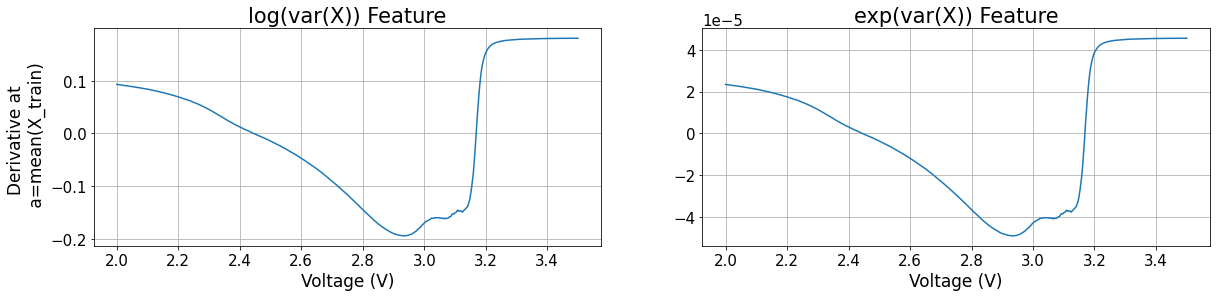

In [15]:
fig, axs = plt.subplots(1,2, figsize=[20, 4])
axs[0].plot(np.linspace(3.5,2.0,1000), jacfwd(logvar)(a))
axs[1].plot(np.linspace(3.5,2.0,1000), jacfwd(expvar)(a))

axs[0].set_title('log(var(X)) Feature')
axs[0].set_xlabel('Voltage (V)')
axs[0].set_ylabel('Derivative at \n a=mean(X_train)')
axs[0].grid()

axs[1].set_title('exp(var(X)) Feature')
axs[1].set_xlabel('Voltage (V)')
axs[1].grid()
plt.show()

Conclusion: Due to the structure  of the sum rule, the reconstructed coefficients only give insights about the INNER function. 
The derivative of the outer function only enters a scalar multiplicator. 
- In the subsequent OLS step this factor will be made redundant. 
- Thus the methodolofy leads to excatly the same results regardless of the outer function. 

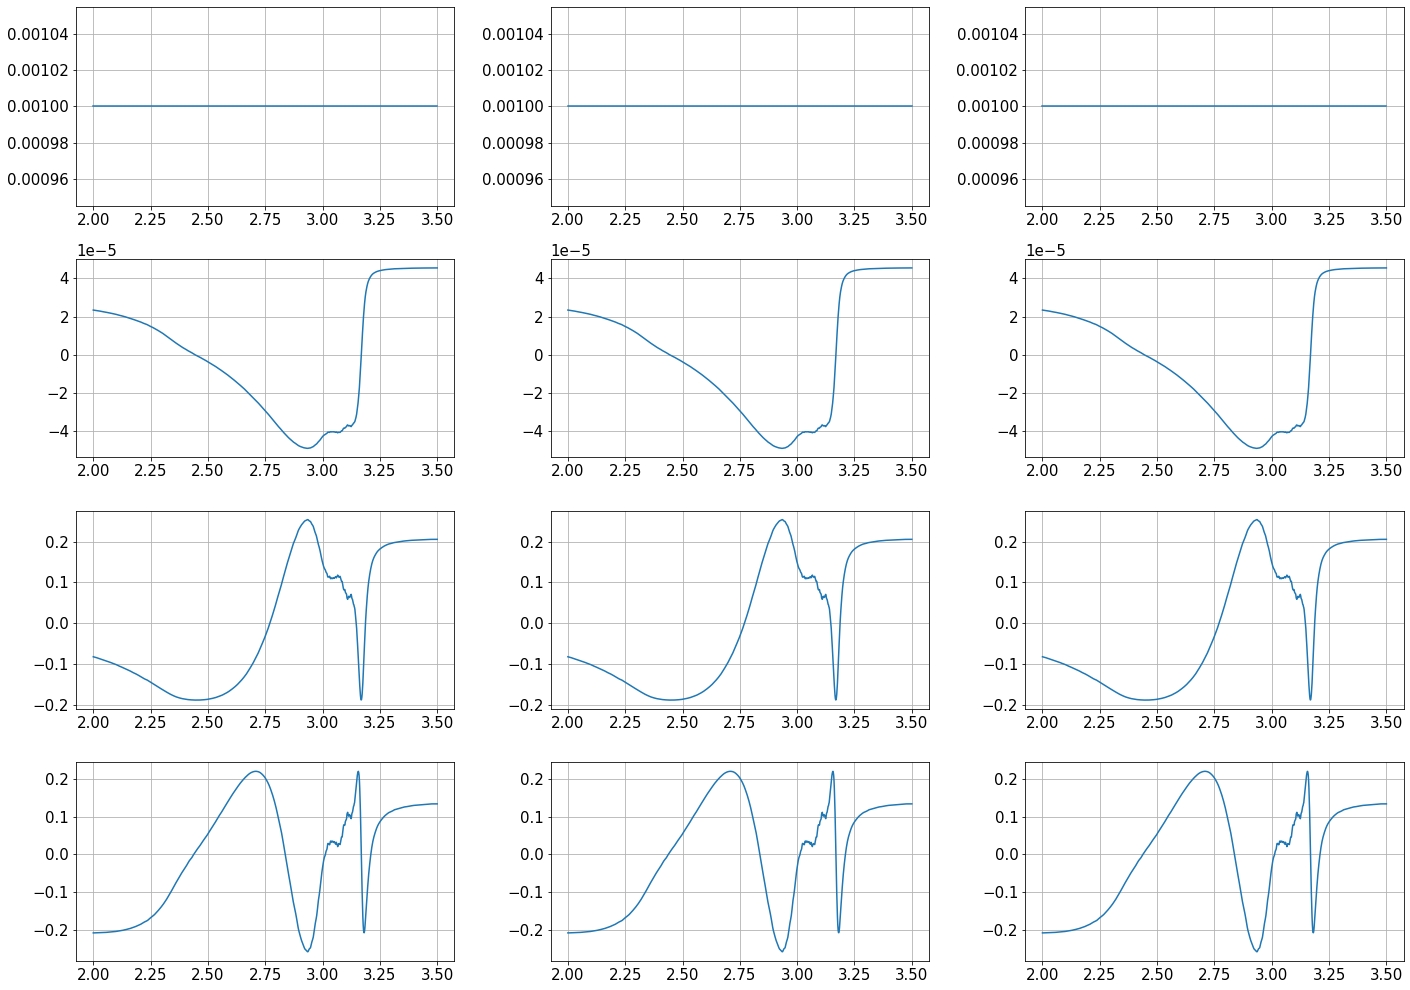

In [16]:
fig, axs = plt.subplots(4,3, figsize=[20, 14])
for i in range(4):  
    for j in range(3):
        axs[i,j].plot(np.linspace(3.5,2.0,1000), jacfwd(rm_to_rone(i))(a))
        axs[i,j].grid()
plt.tight_layout()
plt.show()

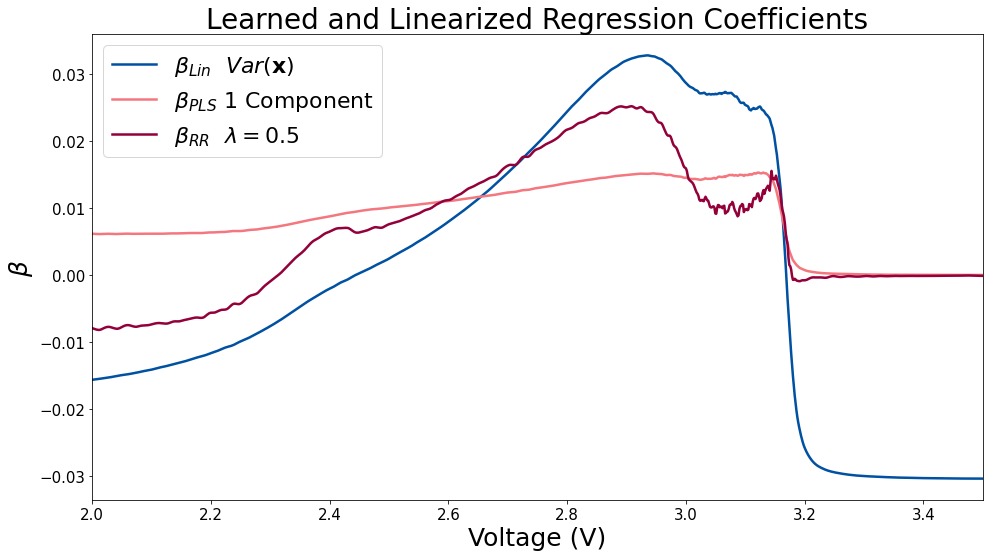

In [17]:
colors = ['#0051a2', '#97964a', '#f4777f', '#93003a']
fig, axs = plt.subplots(figsize=(14,8))
for i in [1]:  
    fun = rm_to_rone(i)
    lin_coef_, lin_const_coef = regress_linearized_coeff(X_train, y_train, fun)
    
    axs.plot(np.linspace(3.5,2.0,1000), lin_coef_, label=r'$\beta_{Lin}$  $Var(\mathbf{x})$', lw=2.5, color=colors[0])
    axs.plot(np.linspace(3.5,2.0,1000), pls1.coef_, label=label_reg[0], lw=2.5, color=colors[2])
    axs.plot(np.linspace(3.5,2.0,1000), rr_coef, label=r'$\beta_{RR}$  $\lambda=0.5$', lw=2.5, color=colors[3])
    # axs.grid()
    axs.legend(loc=2, fontsize=22)
    
axs.set_title('Learned and Linearized Regression Coefficients', fontsize=28)
axs.set_xlabel('Voltage (V)', fontsize=25)
axs.set_ylabel(r'$\beta$', fontsize=25)
axs.set_xlim([2.0,3.5])
plt.tight_layout()
plt.savefig('Var_Feature_Lin.pdf', bbox_inches='tight', dpi=300)
plt.show()

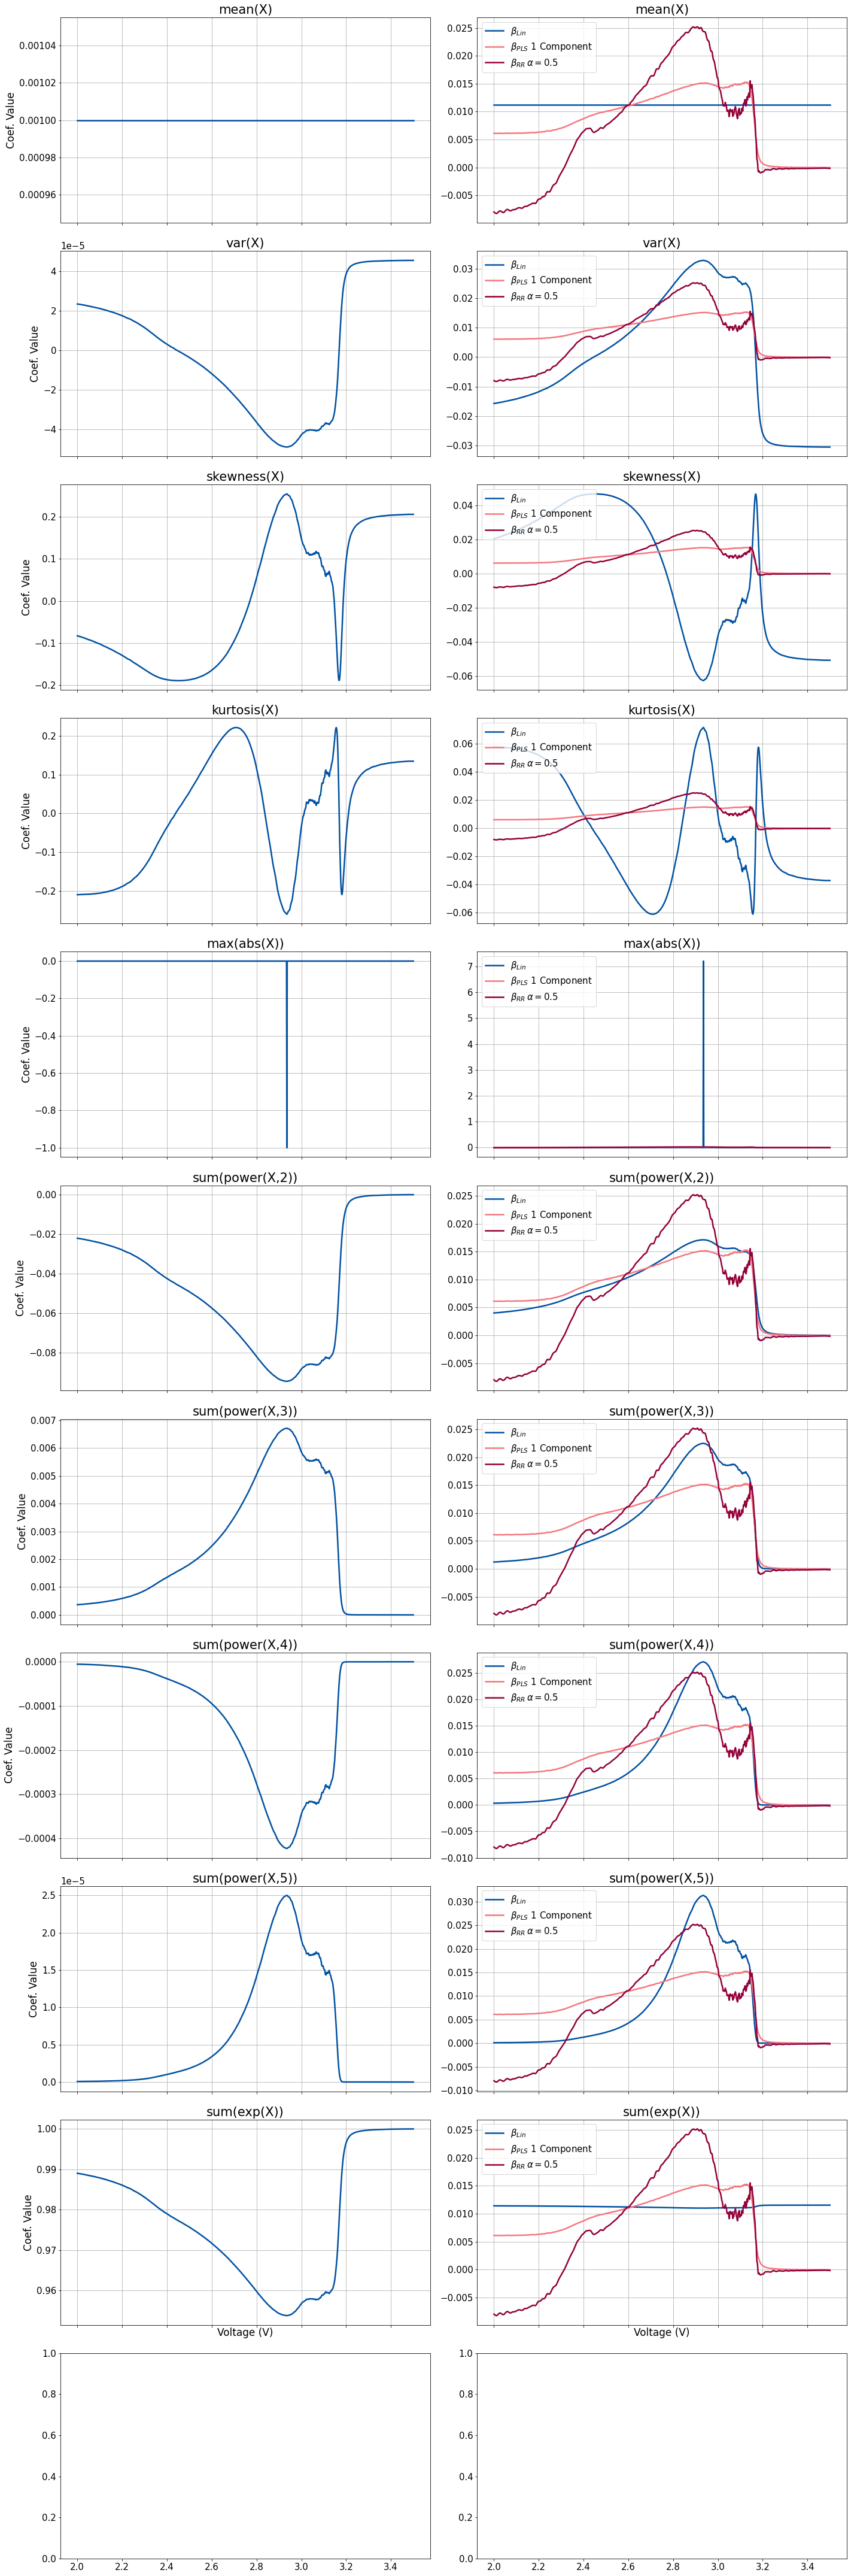

In [18]:
# TODO: Make table with correponding regression coefficients.

colors = ['#0051a2', '#97964a', '#f4777f', '#93003a']
fig, axs = plt.subplots(10, 2, figsize=[20,60], sharex=True)
for i in range(10):  
    fun = rm_to_rone(i)
    grad = jacfwd(fun)
    lin_coef_, lin_const_coef = regress_linearized_coeff(X_train, y_train, fun)
    axs[i,0].plot(np.linspace(3.5,2.0,1000), grad(a), lw=2.5, color=colors[0])
    axs[i,0].set_title(rm_to_rone_names[i])
    axs[i,0].grid()
    axs[i,0].set_ylabel('Coef. Value')
    
    axs[i,1].set_title(rm_to_rone_names[i])
    axs[i,1].plot(np.linspace(3.5,2.0,1000), lin_coef_, label=r'$\beta_{Lin}$', lw=2.5, color=colors[0])
    axs[i,1].plot(np.linspace(3.5,2.0,1000), pls1.coef_, label=label_reg[0], lw=2.5, color=colors[2])
    axs[i,1].plot(np.linspace(3.5,2.0,1000), rr_coef, label=label_reg[1], lw=2.5, color=colors[3])
    axs[i,1].grid()
    axs[i,1].legend(loc=2)
    
    
axs[i,0].set_xlabel('Voltage (V)')
axs[i,1].set_xlabel('Voltage (V)')

plt.tight_layout()
plt.show()

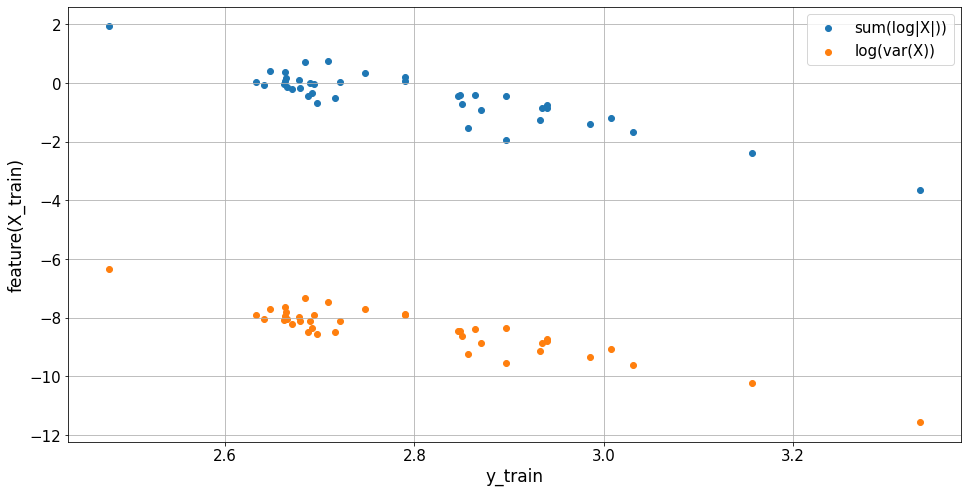

In [19]:
plt.scatter(y_train, np.log((np.sum(np.power(X_train, 2), axis=1))), label='sum(log|X|))')
plt.scatter(y_train, np.log((np.var(X_train, axis=1))), label='log(var(X))')
plt.legend()
plt.grid()
plt.ylabel('feature(X_train)')
plt.xlabel('y_train')

plt.show()
# Demonstration of how autodifferentiation works

# lin_vec = np.linspace(1, 10, 100)
# plt.plot(np.linspace(1, 10, 100), np.log(lin_vec))
# plt.plot(np.linspace(1, 10, 100), 0.0001*np.exp(lin_vec))
# plt.plot(np.linspace(1, 10, 100), np.power(lin_vec, 0.3))
# plt.plot(np.linspace(1, 10, 100), 0.01*np.power(lin_vec, 2))

### Learnings: 

If we would have followed the advice of the linearized feature comparison, we would have chosen sum(X^2) which is reasonable close to variance featuer but not as good.

We cannot learn anything about the outer feature transformations i.e. transformations from (R1 --> R1). If linearized, they contribute only a scalar weight to the equation which will be redundant. Thus correlation analysis will still be needed for feature design/engineering. 

We can clearly see, that some feetures simply don't make sence, given the data. 

Conclusions: 
The linearization analysis can give insights into features and might lead to further insights reagarding interpretation of features and voltage ranges and allso to compare feature based approaches directly with learned regression coefficients. 

However, the value for feature guidance and feature discivery is limited and a we recommed to carry out a correlation analysis in addition. 



### Voltage ranges ideas: 

In particular, we know, that the Voltage range from 3.3 -- 3.5 V has very little information, in comparison wiht the other sections. Furthermore, we can see very different coefficient values in the section 3.0 - 3.2 V. This is consistent with analysing different train test splits/crossvalidationof different splits. We then also observe very different values for this voltage section depending on the split, however, this is more complicated. 

1. This voltage ssection carries very valuable information, at least for the training and primary test set. 
2. This voltage section leads to a certain confusion for cells from batch 8. I assume this is due to the different amount of calendar ageing that manifest itself differently at those number of cycles. If we exclude thte region 3.1-3.5 V, we get better for some cells but trade accuracy for other cells. 


One way to go about this would be to use feature tranaforamtions only for the lower voltage range from 2.0-3.0 V. 

### Voltage ranges

Voltage range from 2.0 - 3.0 V

In [20]:
start_v = 3.0
stop_v = 3.5

stop_value = 1000 - int((start_v-2.0)*(1000/(3.5-2.0)))    # position 0 equivalent to 0 V
start_value  = 1000 - int((stop_v-2.0)*(1000/(3.5-2.0)))   # position for 3.0 V

In [21]:
def plot_vrange_pred(start_v, stop_v):
    r_end = 1000 - int((start_v-2.0)*(1000/(3.5-2.0)))    # position 0 equivalent to 0 V
    r_start  = 1000 - int((stop_v-2.0)*(1000/(3.5-2.0)))   # position for 3.0 V

    Vdlin = np.linspace(stop_v, start_v, r_end-r_start)
    
    split_keys = X_dict.keys()
    X_dict_range = dict.fromkeys(split_keys)

    for key in split_keys: 
        X_dict_range[key] = np.zeros([X_dict[key].shape[0], r_end-r_start, 1])
        for i in range(X_dict[key].shape[0]):
            X_dict_range[key][i,:,:] = X_dict[key][i, r_start:r_end, :]
            
    
    fig, ax = plt.subplots(1,2, figsize=(22,12))
    
    # Log Variance! 
    log_var = dict.fromkeys(X_dict_range.keys())
    y_pred_log_var = dict.fromkeys(X_dict_range.keys())

    for key in X_dict_range.keys(): 
        log_var[key] = np.log(np.var(X_dict_range[key], axis=1, ddof=1))

    # Explicit subtraction of the mean not necessary, ususally done anyways during the fitting process itself. 
    # However, it is implemented here explicitly to to show analygies. 
    reg_log_var = LinearRegression(fit_intercept=True).fit(log_var['train'], (y_dict['train']-y_dict['train'].mean()))

    for key in X_dict.keys(): 
        y_pred_log_var[key] = reg_log_var.predict(log_var[key]) + y_dict['train'].mean()

    # Log Var
    ax[1] = plot_prediction_results(
        y_dict, y_pred_log_var, base=10, title='Log Variance',
        return_ax=1, ax=ax[1],  path=path_save, save=0)
    
    ax[0].plot(Vdlin, X_dict_range['train'][5,:,:])
    ax[0].set_xlabel('Voltage (V)')
    ax[0].set_ylabel('DQ_100-10')
    ax[0].set_title('Example Battery')
    plt.show() 
    
    return None 

In [22]:
interact(plot_vrange_pred,
        start_v=ipywidgets.FloatSlider(
                                    value=2.0,
                                    min=2, 
                                    max=3.5, 
                                    step=0.01, 
                                    description='Start Voltage',
                                    continuous_update=True),
        stop_v=ipywidgets.FloatSlider(
                                    value=3.5,
                                    min=2, 
                                    max=3.5, 
                                    step=0.01, 
                                    description='Stop Voltage',
                                    continuous_update=True),)

interactive(children=(FloatSlider(value=2.0, description='Start Voltage', max=3.5, min=2.0, step=0.01), FloatS…

<function __main__.plot_vrange_pred(start_v, stop_v)>

In [23]:
r_end = 1000            # - 0                                 # position 0 equivalent to 0 V
r_start = 280           # - int((3.0-2.0)*(1000/(3.5-2.0)))   # position for 3.0 V

split_keys = X_dict.keys()
X_dict_range = dict.fromkeys(split_keys)

for key in split_keys: 
    X_dict_range[key] = np.zeros([X_dict[key].shape[0], r_end-r_start, 1])
    for i in range(X_dict[key].shape[0]):
        X_dict_range[key][i,:,:] = X_dict[key][i, r_start:r_end, :]

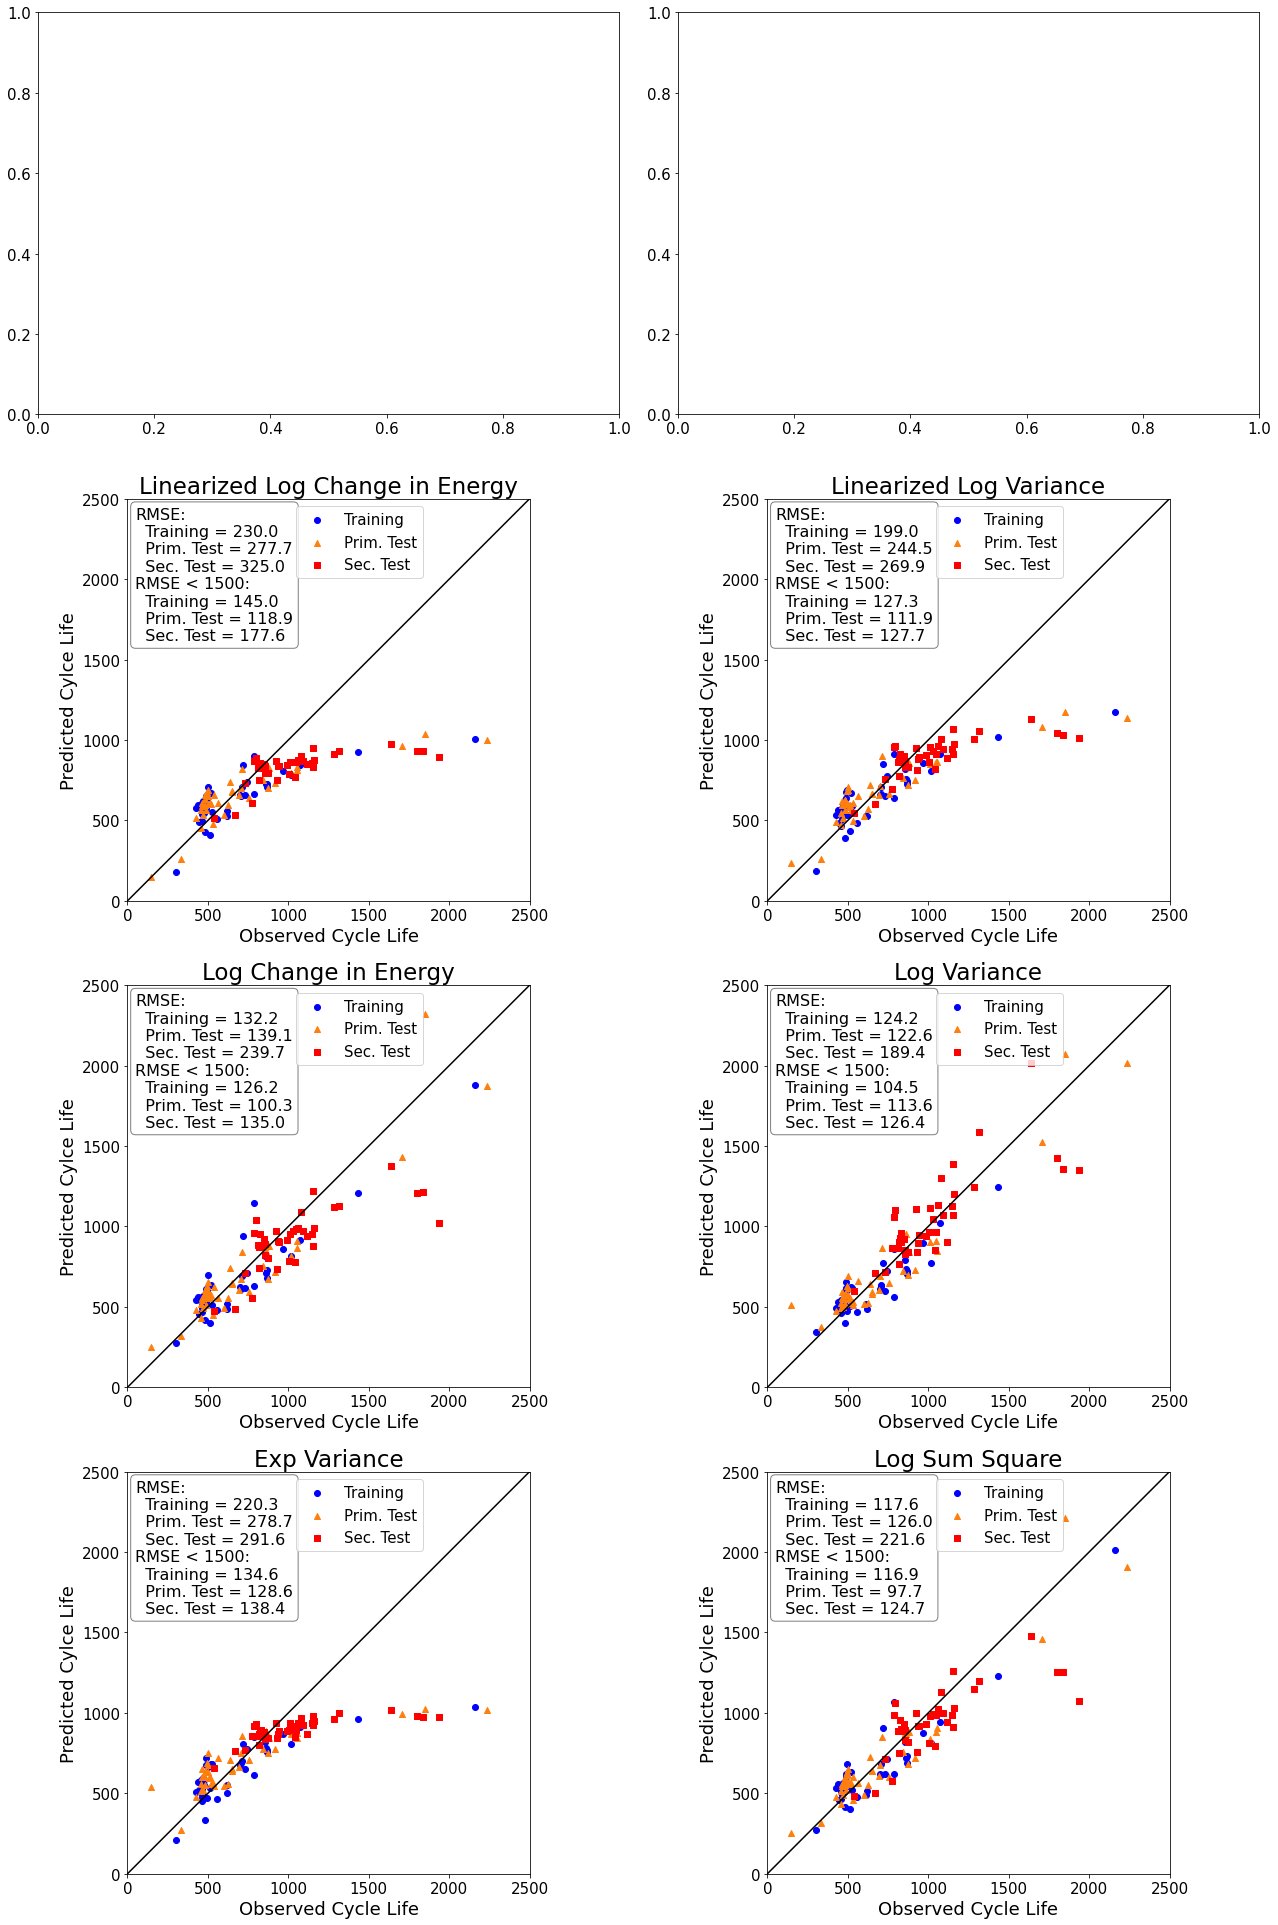

In [24]:
## Could be something for the SI

# Log mean (Change in energy!) 
log_mean = dict.fromkeys(X_dict_range.keys())
y_pred_log_mean = dict.fromkeys(X_dict_range.keys())

for key in X_dict_range.keys(): 
    log_mean[key] = np.log(-np.mean(X_dict_range[key], axis=1))

# Explicit subtraction of the mean not necessary, ususally done anyways during the fitting process itself. 
# However, it is implemented here explicitly to to show analygies. 
reg_log_mean = LinearRegression(fit_intercept=True).fit(log_mean['train'], (y_dict['train']-y_dict['train'].mean()))

for key in X_dict.keys(): 
    y_pred_log_mean[key] = reg_log_mean.predict(log_mean[key]) + y_dict['train'].mean()

# Log Variance! 
log_var = dict.fromkeys(X_dict_range.keys())
y_pred_log_var = dict.fromkeys(X_dict_range.keys())

for key in X_dict_range.keys(): 
    log_var[key] = np.log(np.var(X_dict_range[key], axis=1, ddof=1))

# Explicit subtraction of the mean not necessary, ususally done anyways during the fitting process itself. 
# However, it is implemented here explicitly to to show analygies. 
reg_log_var = LinearRegression(fit_intercept=True).fit(log_var['train'], (y_dict['train']-y_dict['train'].mean()))

for key in X_dict.keys(): 
    y_pred_log_var[key] = reg_log_var.predict(log_var[key]) + y_dict['train'].mean()

# Exp Variance! 
exp_var = dict.fromkeys(X_dict_range.keys())
y_pred_exp_var = dict.fromkeys(X_dict_range.keys())

for key in X_dict_range.keys(): 
    exp_var[key] = np.exp(np.var(X_dict_range[key], axis=1, ddof=1))

# Explicit subtraction of the mean not necessary, ususally done anyways during the fitting process itself. 
# However, it is implemented here explicitly to to show analygies. 
reg_exp_var = LinearRegression(fit_intercept=True).fit(exp_var['train'], (y_dict['train']-y_dict['train'].mean()))

for key in X_dict.keys(): 
    y_pred_exp_var[key] = reg_exp_var.predict(exp_var[key]) + y_dict['train'].mean()

# Sumsquares! 
sum_sq = dict.fromkeys(X_dict_range.keys())
y_pred_sum_sq = dict.fromkeys(X_dict_range.keys())

for key in X_dict_range.keys(): 
    sum_sq[key] = np.log(np.sum(np.power(X_dict_range[key], 2), axis=1))

# Explicit subtraction of the mean not necessary, ususally done anyways during the fitting process itself. 
# However, it is implemented here explicitly to to show analygies. 
reg_sum_sq = LinearRegression(fit_intercept=True).fit(sum_sq['train'], (y_dict['train']-y_dict['train'].mean()))

for key in X_dict.keys(): 
    y_pred_sum_sq[key] = reg_sum_sq.predict(sum_sq[key]) + y_dict['train'].mean()

## Plots of regression results

# Regression results plot: 
fig, ax = plt.subplots(4,2, figsize=(18,27))

# Lin Log Mean
ax[1,0] = plot_prediction_results(
    y_dict, y_pred_taylor_log_mean, base=10, title='Linearized Log Change in Energy',
    return_ax=1, ax=ax[1,0],  path=path_save, save=0)

# Lin Log Var
ax[1,1] = plot_prediction_results(
    y_dict, y_pred_taylor_log_var, base=10, title='Linearized Log Variance',
    return_ax=1, ax=ax[1,1],  path=path_save, save=0)

# Log Mean
ax[2,0] = plot_prediction_results(
    y_dict, y_pred_log_mean, base=10, title='Log Change in Energy',
    return_ax=1, ax=ax[2,0],  path=path_save, save=0)

# Log Var
ax[2,1] = plot_prediction_results(
    y_dict, y_pred_log_var, base=10, title='Log Variance',
    return_ax=1, ax=ax[2,1],  path=path_save, save=0)

# Exp Var
ax[3,0] = plot_prediction_results(
    y_dict, y_pred_exp_var, base=10, title='Exp Variance',
    return_ax=1, ax=ax[3,0],  path=path_save, save=0)

# Sum Square
ax[3,1] = plot_prediction_results(
    y_dict, y_pred_sum_sq, base=10, title='Log Sum Square',
    return_ax=1, ax=ax[3,1],  path=path_save, save=0)
plt.tight_layout()
if save_plots:
    plt.savefig('../../03Results/OverviewRegressionResults.png', bbox_inches='tight', dpi=300)